In [2]:
import torch

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as VT
import torchvision.transforms.functional as VF

import torchmetrics

import pathlib
import PIL.Image

import numpy as np
import matplotlib.pyplot as plt
import random

from tqdm import tqdm

import ipywidgets as ipyw

In [3]:
torch.manual_seed(0)

In [4]:
LABELS = ['wP', 'wN', 'wB', 'wR', 'wQ', 'wK', 'bP', 'bN', 'bB', 'bR', 'bQ', 'bK', 'empty']

In [5]:
augument = VT.Compose([
    VT.RandomChoice([lambda x: x, VT.GaussianBlur(3), VT.GaussianBlur(5)]),
    VT.RandomAffine(5, (0.2, 0.2), (0.8, 1.2), [-5, 5]),
    VT.Lambda(lambda x: VF.adjust_brightness(x, float(torch.empty(1).uniform_(0.5, 1.2)))),
])

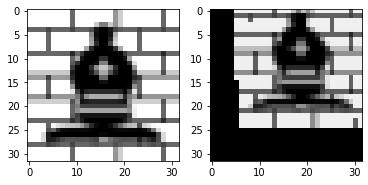

In [6]:
# Example of augumented data

def show(x, ax=plt):
    if isinstance(x, np.ndarray):
        x = Image.fromarray(x)
    if isinstance(x, torch.Tensor):
        x = VF.to_pil_image(x)
    x = x.convert('RGB')
    ax.imshow(x)

filename = 'data/train/bB--cburnett-ex000.png'
before = PIL.Image.open(filename).convert('L')
t = VF.to_tensor(before).unsqueeze(0)
t = augument(t)[0]
after = VF.to_pil_image(t)

fig, axes = plt.subplots(1, 2)
show(before, axes[0])
show(after, axes[1])

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dirname):
        super(torch.utils.data.Dataset, self).__init__()
        self.files = sorted(pathlib.Path(dirname).glob('*.png'))
    
    def __getitem__(self, i):
        file = self.files[i]
        image = PIL.Image.open(file)
        assert image.mode == 'RGB'
        image = image.convert('L')
        x = VF.to_tensor(image)
        label = file.name.split('--')[0]
        y = torch.LongTensor([LABELS.index(label)])
        return x, y
    
    def __len__(self):
        return len(self.files)

In [10]:
dataset = Dataset('data/train')

len_total = len(dataset)
len_test = int(0.05 * len_total)
len_train = len_total - len_test

trainset, testset = torch.utils.data.random_split(dataset, [len_train, len_test])
len(trainset), len(testset)

(5985, 314)

In [11]:
BATCH_SIZE = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE)

In [13]:
#
# Define model
#
import torch
import torch.nn as nn
import torch.nn.functional as F

in_h = in_w = 32
out_size = 13

def make_model():
    return nn.Sequential(
        nn.Conv2d(1, 4, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(4, 4, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(4, 4, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(4 * in_h * in_w, 256),
        nn.Dropout(0.3),
        nn.Linear(256, 256),
        nn.Dropout(0.3),
        nn.ReLU(),
        nn.Linear(256, out_size),
    )

make_model()

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=256, bias=True)
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=256, out_features=256, bias=True)
  (10): Dropout(p=0.3, inplace=False)
  (11): ReLU()
  (12): Linear(in_features=256, out_features=13, bias=True)
)

In [14]:
def to_loss(y, yt):
    return F.cross_entropy(y, yt)

def to_prediction(y):
    return y.argmax(dim=-1)

def to_probability(y):
    return torch.max(F.softmax(y, dim=-1), dim=-1).values

In [21]:
def train(model, num_epochs):
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epochs):
        metric = torchmetrics.Accuracy()
        model.train()
        with tqdm(trainloader) as it:
            for x, yt in it:
                optimizer.zero_grad()
                x = augument(x)
                y = model(x)
                yt = yt.reshape(-1)
                yl = to_loss(y, yt)
                yl.backward()
                optimizer.step()
                metric(to_prediction(y), yt)
                it.set_postfix(acc=float(metric.compute()))

        metric = torchmetrics.Accuracy()    
        model.eval()
        with tqdm(testloader) as it:
            for x, yt in it:
                y = model(x)
                yt = yt.reshape(-1)
                yl = to_loss(y, yt)
                metric(to_prediction(y), yt)
                it.set_postfix(acc=float(metric.compute()))

In [22]:
model = make_model()
train(model, num_epochs=128)

100%|██████████| 375/375 [00:12<00:00, 30.82it/s, acc=0.948]


100%|██████████| 20/20 [00:00<00:00, 78.65it/s, acc=0.994]


In [23]:
#
# Save model
#

from datetime import datetime

timestamp = datetime.strftime(datetime.now(), "%F-%H-%M-%S")
filename = f"data/checkpoint/model-{timestamp}.pt"
torch.save({'model_state_dict': model.state_dict()}, filename)
print(filename)

data/checkpoint/model-2021-05-12-22-17-10.pt


In [24]:
#
# Load model
#
checkpoint_file = 'data/checkpoint/model-2021-05-12-22-17-10.pt'
checkpoint = torch.load(checkpoint_file)

model = make_model()
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=256, bias=True)
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=256, out_features=256, bias=True)
  (10): Dropout(p=0.3, inplace=False)
  (11): ReLU()
  (12): Linear(in_features=256, out_features=13, bias=True)
)

In [25]:
def predict(model, x):
    x = x.unsqueeze(0)
    y = model(x)[0]
    z = to_prediction(y)
    w = to_probability(y)
    return z, w

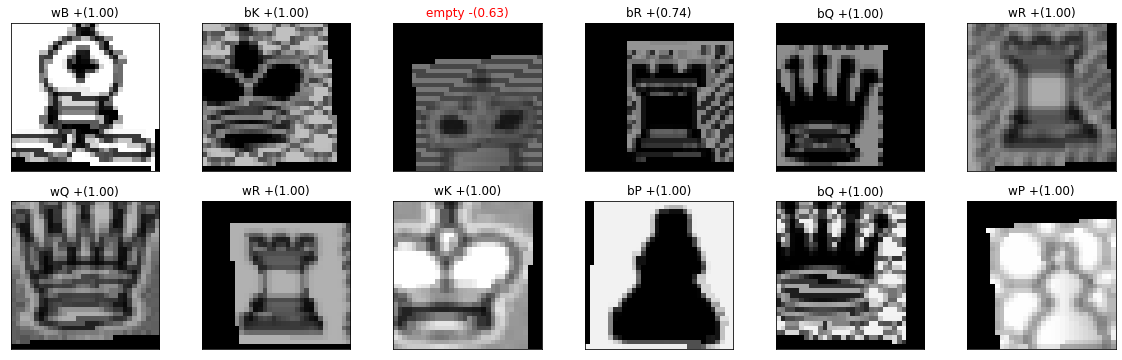

In [28]:
#
# Plot test dataset result
#

def _(k=0):
    h, w = 2, 6
    fig, axes = plt.subplots(h, w, figsize=(20, 6))
    for i in range(h):
        for j in range(w):
            x, y = testset[(k * h + i) * w + j]
            x = augument(x.unsqueeze(0))[0]
            prediction, probability = predict(model, x)
            correct = prediction == y[0]
            title = LABELS[prediction] + ' ' + ('+' if correct else '-') + f"({float(probability):.2f})"
            ax = axes[i][j]
            ax.set_title(title, color='black' if correct else 'red')
            ax.set(title=title, xticks=[], yticks=[])
            ax.imshow(VF.to_pil_image(x).convert('RGB'))

# [ ipywidgets viewer ]
# ipyw.interact(_, k=(0, 1000))

_(4)

In [31]:
#
# Predict pieces on 8x8 board
#

def predict8x8(model, image):
    image = image.convert('L').resize([256, 256])
    x = VF.to_tensor(image)
    x = x.reshape([1, 8, 32, 8, 32]).permute([0, 1, 3, 2, 4]).reshape([64, 1, 32, 32])
    y = model(x)
    z, w = torch.max(torch.softmax(y, dim=-1), dim=-1)
    z = z.reshape([8, 8]).detach()
    w = w.reshape([8, 8]).detach()
    return z, w

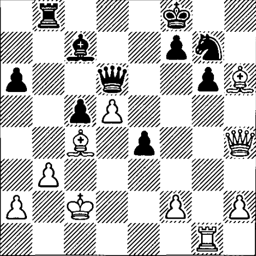

In [32]:
image = PIL.Image.open('data/example/ex000.png').convert('L').resize([256, 256])
image

In [33]:
predict8x8(model, image)

(tensor([[1.0000, 1.0000, 1.0000, 0.9998, 1.0000, 1.0000, 1.0000, 0.9996],
         [0.9995, 1.0000, 1.0000, 1.0000, 0.9996, 1.0000, 1.0000, 1.0000],
         [1.0000, 0.9997, 1.0000, 1.0000, 1.0000, 0.9998, 1.0000, 1.0000],
         [0.9994, 1.0000, 1.0000, 1.0000, 0.9996, 1.0000, 0.9996, 1.0000],
         [1.0000, 0.9996, 1.0000, 0.9996, 1.0000, 0.9997, 1.0000, 1.0000],
         [0.9994, 1.0000, 0.9996, 1.0000, 0.9997, 1.0000, 0.9996, 1.0000],
         [1.0000, 0.9997, 1.0000, 0.9997, 1.0000, 1.0000, 1.0000, 1.0000],
         [0.9999, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]]),
 tensor([[12,  9, 12, 12, 12, 11, 12, 12],
         [12, 12,  8, 12, 12,  6,  7, 12],
         [ 6, 12, 12, 10, 12, 12,  6,  2],
         [12, 12,  6,  0, 12, 12, 12, 12],
         [12, 12,  2, 12,  6, 12, 12,  4],
         [12,  0, 12, 12, 12, 12, 12, 12],
         [ 0, 12,  5, 12, 12,  0, 12,  0],
         [12, 12, 12, 12, 12, 12,  3, 12]]))

In [34]:
#
# Convert to FEN
#

FEN_PIECE_CHARS = ['P', 'N', 'B', 'R', 'Q', 'K', 'p', 'n', 'b', 'r', 'q', 'k']

def to_fen(result):
    fen = ''
    cnt = 0
    for i in range(8):
        if i > 0:
            fen += '/'
        cnt = 0
        for j in range(8):
            piece = result[i][j]
            if piece == 12:
                cnt += 1
            else:
                if cnt > 0:
                    fen += str(cnt)
                fen += FEN_PIECE_CHARS[piece]
                cnt = 0
        if cnt > 0:
            fen += str(cnt)            
    return fen


def predict_fen(model, filename):
    probability, labels = predict8x8(model, PIL.Image.open(filename))
    return to_fen(labels)

1r3k2/2b2pn1/p2q2pB/2pP4/2B1p2Q/1P6/P1K2P1P/6R1


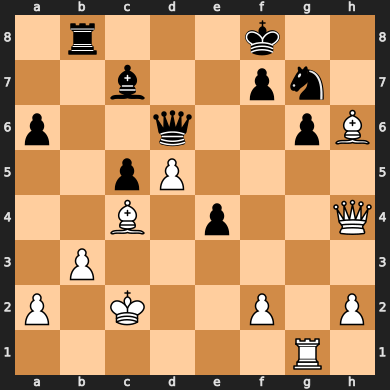

In [35]:
import chess

fen = predict_fen(model, 'data/example/ex000.png')
print(fen)

chess.Board(fen)